In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams, cm
import numpy as np
from scipy.signal import stft, resample, welch
from scipy.fft import fft, ifft
from scipy import signal
from copy import deepcopy as dc

In [2]:
def butter_bandpass(data, lowcut, highcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)

In [3]:
# Imprime os gráficos
def print_graphs(datas):
    rcParams['figure.figsize'] = [16., 10.]

    x = np.linspace(0, 8, 1600)
    fig, ax = plt.subplots(len(datas), 1)

    for i in range(len(datas)):
        for j in range(4):
            ax[i].plot(x, datas[i,j])

    plt.show()

In [4]:
def print_3d_graphs(data):
    rcParams['figure.figsize'] = [18., 6.]

    for trial in (0, 1):
        mov = 1
        plot_data = []
        for channel in range(2):
            # espaço de 1600 pontos entre 0 e 1
            for i, t in enumerate(np.linspace(0, 1, 1600)):
                plot_data.append([channel, t, data[mov][trial][channel][i]])

        plot_data = np.array(plot_data)
        x, y, z = plot_data[:,0], plot_data[:,1], plot_data[:,2]
        ax = plt.axes(projection ='3d')
        ax.set_title('Movimento {}'.format(mov + 1))
        ax.set_xlabel('Canais')
        ax.set_ylabel('Tempo (s)')
        ax.set_zlabel('Potência (mV)')
        ax.plot_trisurf(x, y, z, antialiased=True, cmap=cm.inferno, linewidth=1)
        plt.show()

In [5]:
data1 = np.load('datasets/topicos_cc/s04_1.npy')
data2 = np.load('datasets/topicos_cc/s04_2.npy')
data3 = np.load('datasets/topicos_cc/s04_3.npy')

data = np.array([data1, data2, data3])
data = data.swapaxes(0, 1)
data = data.swapaxes(2, 3)

print(data.shape)

# data = butter_bandpass(data, 5, 50)

(8, 3, 4, 1600)


In [6]:
# Dados de mesma classe e diferentes ensaios
# [classes, ensaios, canais, : ]
d1 = data[0,0,0,:], data[0,0,1,:], data[0,0,2,:], data[0,0,3,:]
d2 = data[0,1,0,:], data[0,1,1,:], data[0,1,2,:], data[0,1,3,:]
d3 = data[0,2,0,:], data[0,2,1,:], data[0,2,2,:], data[0,2,3,:]

datas = np.array([d1, d2, d3])

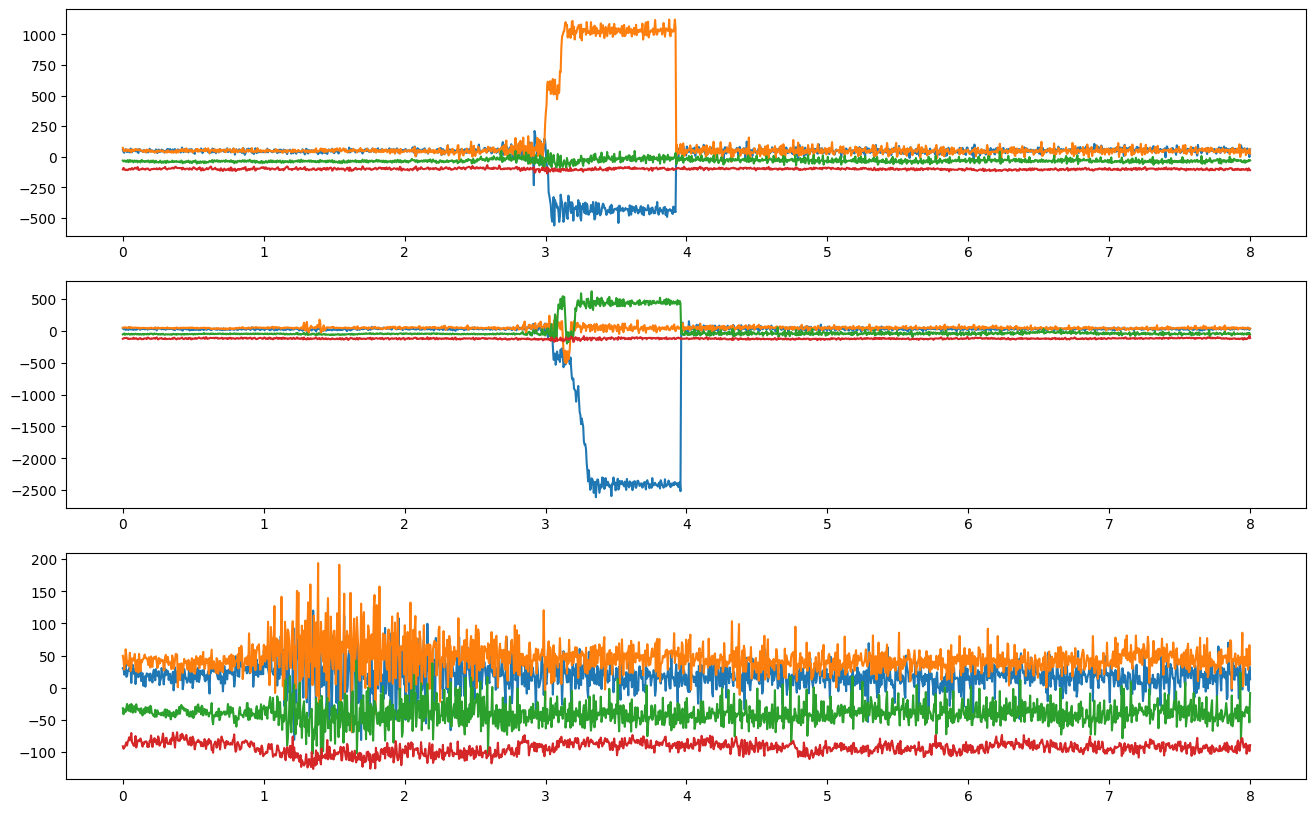

In [7]:
print_graphs(datas)

In [8]:
# Dados de diferentes classes e mesmo ensaio
# [classes, ensaios, canais, : ]
d1 = data[0,0,0,:], data[0,0,1,:], data[0,0,2,:], data[0,0,3,:]
d2 = data[1,0,0,:], data[1,0,1,:], data[1,0,2,:], data[1,0,3,:]
d3 = data[2,0,0,:], data[2,0,1,:], data[2,0,2,:], data[2,0,3,:]
d4 = data[3,0,0,:], data[3,0,1,:], data[3,0,2,:], data[3,0,3,:]
d5 = data[4,0,0,:], data[4,0,1,:], data[4,0,2,:], data[4,0,3,:]
d6 = data[5,0,0,:], data[5,0,1,:], data[5,0,2,:], data[5,0,3,:]
d7 = data[6,0,0,:], data[6,0,1,:], data[6,0,2,:], data[6,0,3,:]
d8 = data[7,0,0,:], data[7,0,1,:], data[7,0,2,:], data[7,0,3,:]

datas2 = np.array([d1, d2, d3, d4, d5, d6, d7, d8])

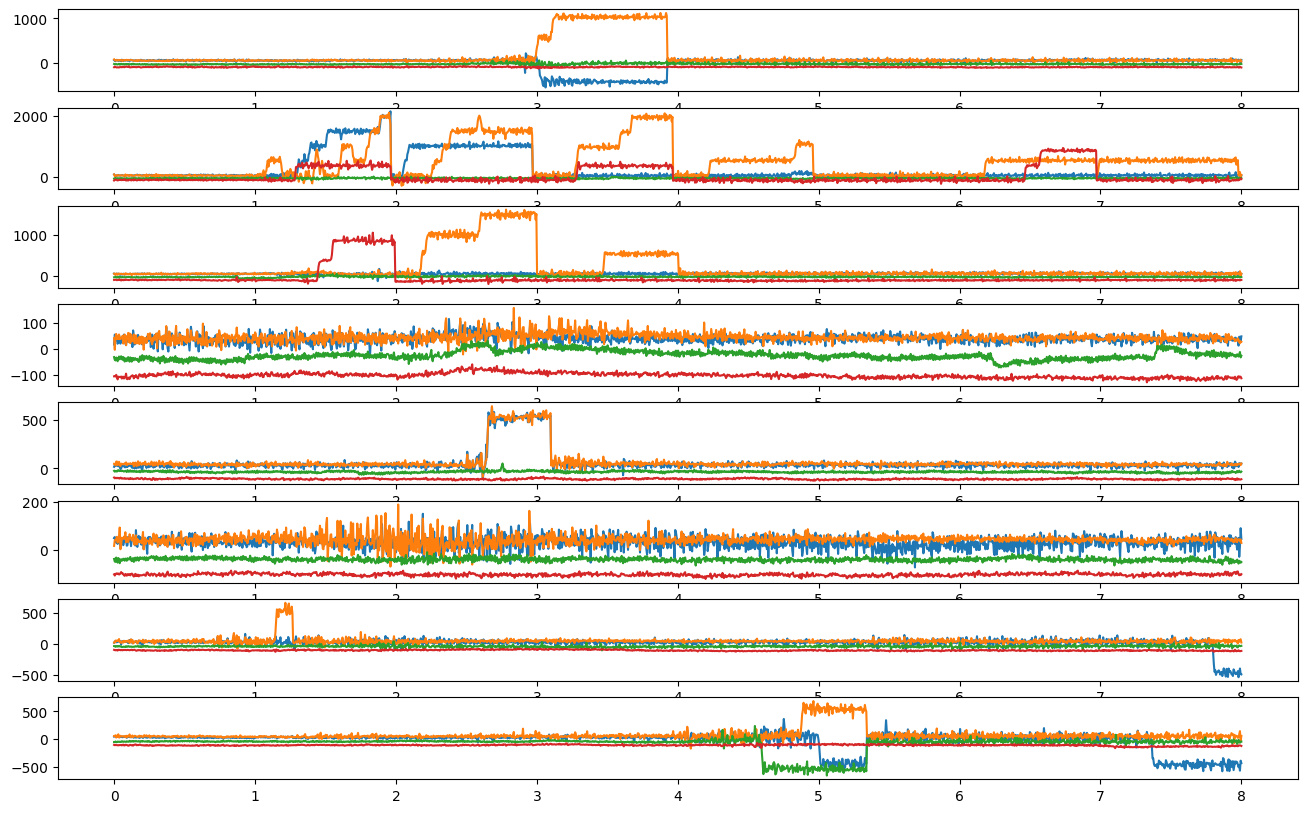

In [9]:
print_graphs(datas2)

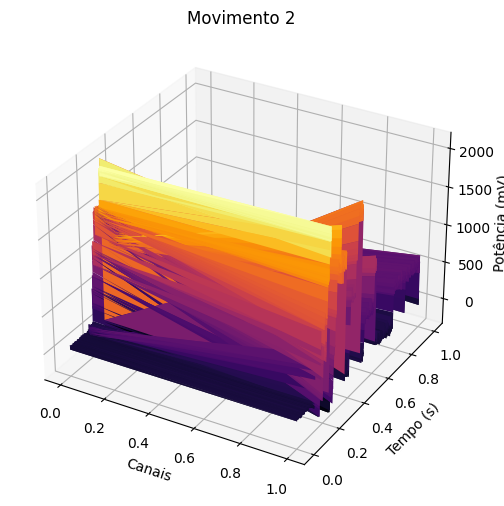

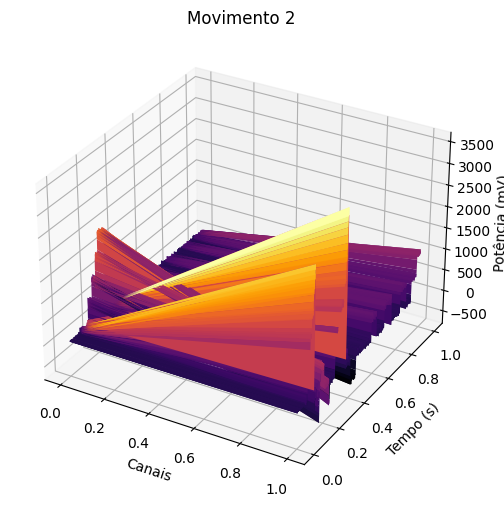

In [10]:
print_3d_graphs(data)

## Tarefa 2


In [11]:
from scipy.signal import stft

step = 47
segment = 64
print('', data.shape)
dataR = data.reshape(24, 4, 1600)
print('', dataR.shape)

n_win = int((dataR.shape[-1] - segment) / step) + 1
ids = np.arange(n_win) * step

# Janelas do dado no dominio do tempo
chunks_time = np.array([dataR[:,:,k:(k + segment)] for k in ids]).transpose(1, 2, 0, 3)

# Janelas do dado no domínio da frequência
_, _, chunks_freq = stft(dataR, fs=200, nperseg=64, noverlap=32)
# chunks_freq = np.swapaxes(chunks_freq, 2, 3)

f, chunks_welch = welch(dataR, fs=200, nperseg=64, noverlap=32)

print('Formato (shape) dos dados depois da divisão de janelas')
print(f'Dominio do tempo: {chunks_time.shape} - (classes+ensaios, canais, janelas, linhas)')
print(f'Dominio da frequência:  {chunks_freq.shape} - (classes+ensaios, canais, janelas, linhas)')
print(f'Dominio da frequência (welch):  f: {f.shape}, chunks_welch: {chunks_welch.shape} - (classes+ensaios, canais, janelas, linhas)')

 (8, 3, 4, 1600)
 (24, 4, 1600)
Formato (shape) dos dados depois da divisão de janelas
Dominio do tempo: (24, 4, 33, 64) - (classes+ensaios, canais, janelas, linhas)
Dominio da frequência:  (24, 4, 33, 51) - (classes+ensaios, canais, janelas, linhas)
Dominio da frequência (welch):  f: (33,), chunks_welch: (24, 4, 33) - (classes+ensaios, canais, janelas, linhas)


## Tarefa 3

In [12]:
# funções auxiliares
def PSD(w):
    return np.abs(w) ** 2

def wamp(x, threshold):
    return np.sum(np.abs(np.diff(x)) > threshold, axis=-1)

def var(x):
    return np.sum(x ** 2, axis=-1) / (np.prod(x.shape) - 1)

def rms(x):
    return np.sqrt(np.sum(np.abs(x) ** 2, axis=-1) / (np.prod(x.shape) - 1))

def wl(x):
    return np.abs(np.diff(x, axis=-1)).sum(axis=-1)

def zc(x):
    return np.sum(np.diff(np.sign(x), axis=-1) != 0, axis=-1)

def fmd(w):
    return np.sum(PSD(w), axis=-1) / 2

def fmn(w):
    _,_,_,M = w.shape
    f_j = (np.arange(1, M+1) * 200 )/ (2 * M)  # Frequências correspondentes a cada índice
    weighted_sum = np.sum(f_j * PSD(w))
    mean_freq = weighted_sum / fmd(w)*2
    return mean_freq

def mmdf(w):
    return np.sum(np.abs(w), axis=-1) / 2

def mmnf(w):
    _,_,_,M = w.shape
    f_j = np.arange(1, M+1) * 200 / (2 * M) 
    weighted_sum = np.sum(f_j * np.abs(w), axis=-1)
    mean_freq = weighted_sum / mmdf(w)*2
    return mean_freq

In [13]:
final_data = list()
final_data.append(fmd(chunks_freq))
final_data.append(mmdf(chunks_freq))
final_data.append(fmn(chunks_freq))
final_data.append(mmnf(chunks_freq))
final_data.append(var(chunks_time))
final_data.append(rms(chunks_time))
final_data.append(wamp(chunks_time, 0))
final_data.append(wl(chunks_time))
final_data.append(zc(chunks_time))
final_data.append(chunks_welch)

final = np.array(final_data)
# print(final)
np.save("./datasets/caracteristicas/S04",final)

## Tarefa 4

### Transformação

In [14]:
print(final.shape)
dataX = final.swapaxes(1,2)
dataX = dataX.reshape(40, 792)
dataX = dataX.swapaxes(0,1)
print("Shape: ", dataX.shape)

(10, 24, 4, 33)
Shape:  (792, 40)


In [15]:
def plotPcaScatter(X):
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    import seaborn as sns

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    # Configuração do tamanho do gráfico scatterplot 
    axs[0, 0].remove()  # remove o subplot em [0, 0]
    axs[0, 1].remove()  # remove o subplot em [0, 1]
    ax1 = fig.add_subplot(2, 1, 1)  # adiciona um subplot maior no topo

    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='Set1', ax=ax1)
    ax1.set_title('Scatter plot of the 2 principal components')

    axs[1, 0].bar(np.arange(1, X.shape[1] + 1), pca.components_[0])
    axs[1, 0].set_xlabel('Features')
    axs[1, 0].set_ylabel('Loading no Primeiro Componente Principal')
    axs[1, 0].set_title('PCA 1')

    axs[1, 1].bar(np.arange(1, X.shape[1] + 1), pca.components_[1])
    axs[1, 1].set_xlabel('Features')
    axs[1, 1].set_ylabel('Loading no Segundo Componente Principal')
    axs[1, 1].set_title('PCA 2')

    plt.tight_layout()
    plt.show()

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, SelectPercentile, GenericUnivariateSelect
from sklearn.feature_selection import f_classif

protocol = [0,1,2,3,4,5,6,7]
y = np.repeat(protocol, 99, axis=None)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataX)

selector = SelectKBest(score_func=f_classif, k=8)
fit = selector.fit(X_scaled, y)

X_selected_features = fit.transform(X_scaled)

X_selected_features.shape

(792, 8)

Original features:  40


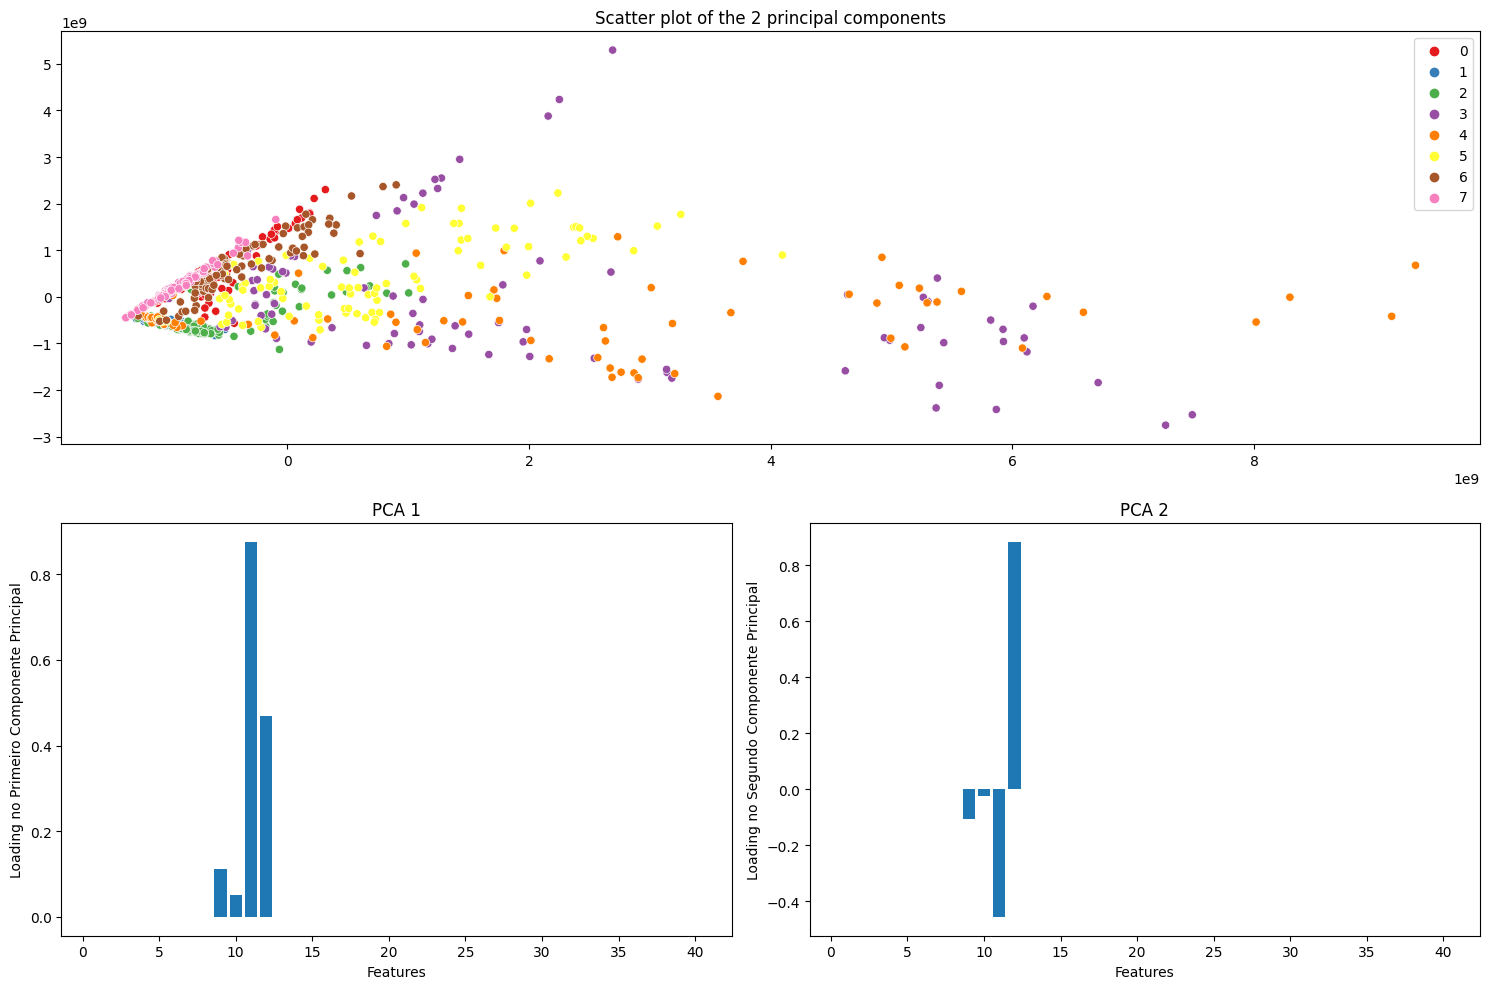

Selected features:  8


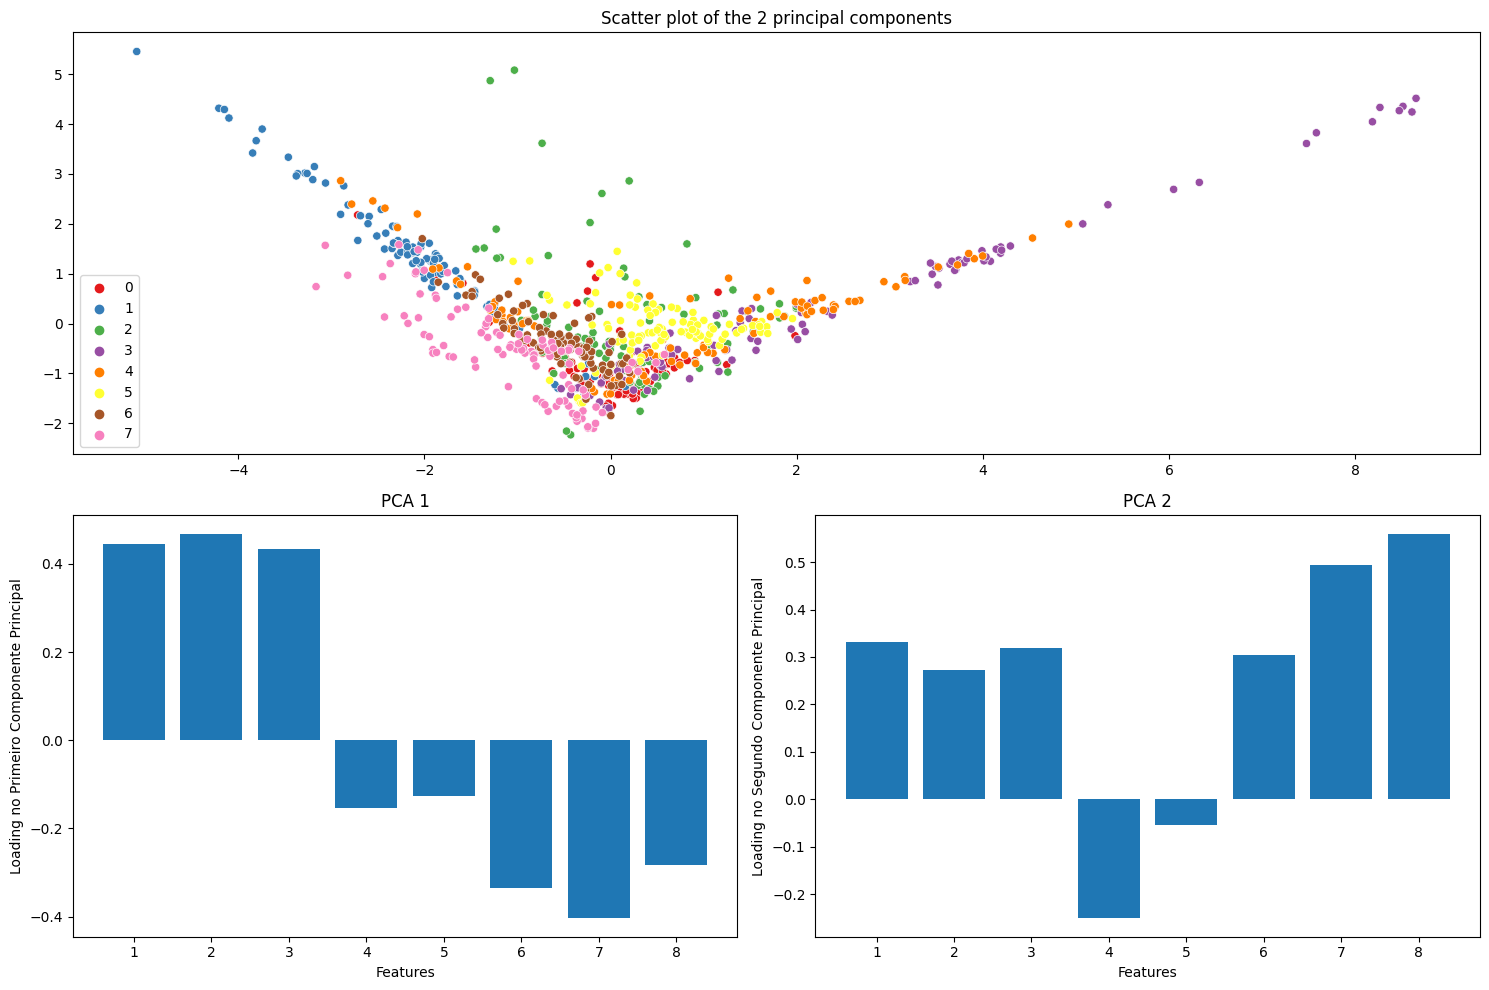

In [17]:
print('Original features: ', dataX.shape[1])
plotPcaScatter(dataX)

print('Selected features: ', X_selected_features.shape[1])
plotPcaScatter(X_selected_features)

### Teste SVM

In [18]:
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler)
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import svm, metrics

protocol = [0,1,2,3,4,5,6,7]
y = np.repeat(protocol, 99, axis=None) # 0,0,0,0,1,1,1,1,2,2,2,2,....7,7,7,7
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataX)

# dividindo as porções de dados em treino e teste (70 e 30% respectivamente)
# com embaralhamento sempre ativo (shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True)

# modelo de classificador com os parâmetros padrões
clf = SVC()

# criando o modelo de classificação com os dados de treino
clf.fit(X_train, y_train)

# aplicando o classificador nos dados de teste
res = clf.predict(X_test)
print(metrics.classification_report(y_test, res, digits=5))

              precision    recall  f1-score   support

           0    0.74194   0.63889   0.68657        36
           1    0.92308   0.96000   0.94118        25
           2    1.00000   0.81250   0.89655        32
           3    0.72414   0.75000   0.73684        28
           4    0.84000   0.77778   0.80769        27
           5    0.82759   0.92308   0.87273        26
           6    0.77143   0.69231   0.72973        39
           7    0.59459   0.88000   0.70968        25

    accuracy                        0.78992       238
   macro avg    0.80284   0.80432   0.79762       238
weighted avg    0.80340   0.78992   0.79104       238



## Tarefa 5

In [19]:
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler)

for scaler in (StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler()):
    X_scaled = scaler.fit_transform(dataX)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True)
    clf = SVC(kernel='rbf', gamma='scale')
    clf.fit(X_train, y_train)
    res = clf.predict(X_test)
    tot_hit = sum([1 for i in range(len(res)) if res[i] == y_test[i]])
    print('Acurácia: {:.2f}%'.format(tot_hit / X_test.shape[0] * 100))

Acurácia: 79.83%
Acurácia: 73.95%
Acurácia: 69.33%
Acurácia: 17.23%


## Tarefa 6

In [39]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [21]:
import matplotlib.pyplot as plt

def plot_history(h):
    loss_list = [s for s in h.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in h.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in h.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in h.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Custo não está presente no histórico')
        return
    epochs = range(1, len(h.history[loss_list[0]]) + 1)
    # Custo
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, h.history[l], 'b',
                 label='Custo [treinamento] (' + str(str(format(
                    h.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, h.history[l], 'g',
                 label='Custo [validação] (' + str(str(format(
                    h.history[l][-1],'.5f'))+')'))
    plt.title('Custo')
    plt.xlabel('Épocas')
    plt.ylabel('Custo')
    plt.legend()
    # Acurácia
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, h.history[l], 'b',
                 label='Acurácia [treinamento] (' + str(format(
                    h.history[l][-1],'.5f'))+')')
    for l in val_acc_list:
        plt.plot(epochs, h.history[l], 'g',
                 label='Acurácia [validação] (' + str(format(
                    h.history[l][-1],'.5f'))+')')
    plt.title('Acurácia')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.show()

In [29]:
protocol = [0,1,2,3,4,5,6,7]
y = np.repeat(protocol, 99, axis=None) # 0,0,0,0,1,1,1,1,2,2,2,2,....7,7,7,7
y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((554, 40), (238, 40), (554, 8), (238, 8))

In [30]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/40
70/70 [==============================] - 0s 3ms/step - loss: 0.3596 - accuracy: 0.8863 - val_loss: 2.0621 - val_accuracy: 0.7647
Epoch 2/40
70/70 [==============================] - 0s 2ms/step - loss: 0.3126 - accuracy: 0.8863 - val_loss: 2.1998 - val_accuracy: 0.7689
Epoch 3/40
70/70 [==============================] - 0s 3ms/step - loss: 0.3627 - accuracy: 0.8917 - val_loss: 2.1660 - val_accuracy: 0.7815
Epoch 4/40
70/70 [==============================] - 0s 2ms/step - loss: 0.3495 - accuracy: 0.9007 - val_loss: 2.3162 - val_accuracy: 0.7773
Epoch 5/40
70/70 [==============================] - 0s 2ms/step - loss: 0.4299 - accuracy: 0.9134 - val_loss: 2.3686 - val_accuracy: 0.7815
Epoch 6/40
70/70 [==============================] - 0s 3ms/step - loss: 0.3783 - accuracy: 0.9097 - val_loss: 2.1863 - val_accuracy: 0.7773
Epoch 7/40
70/70 [==============================] - 0s 4ms/step - loss: 0.2841 - accuracy: 0.9170 - val_loss: 2.1148 - val_accuracy: 0.7857
Epoch 8/40
70/70 [==

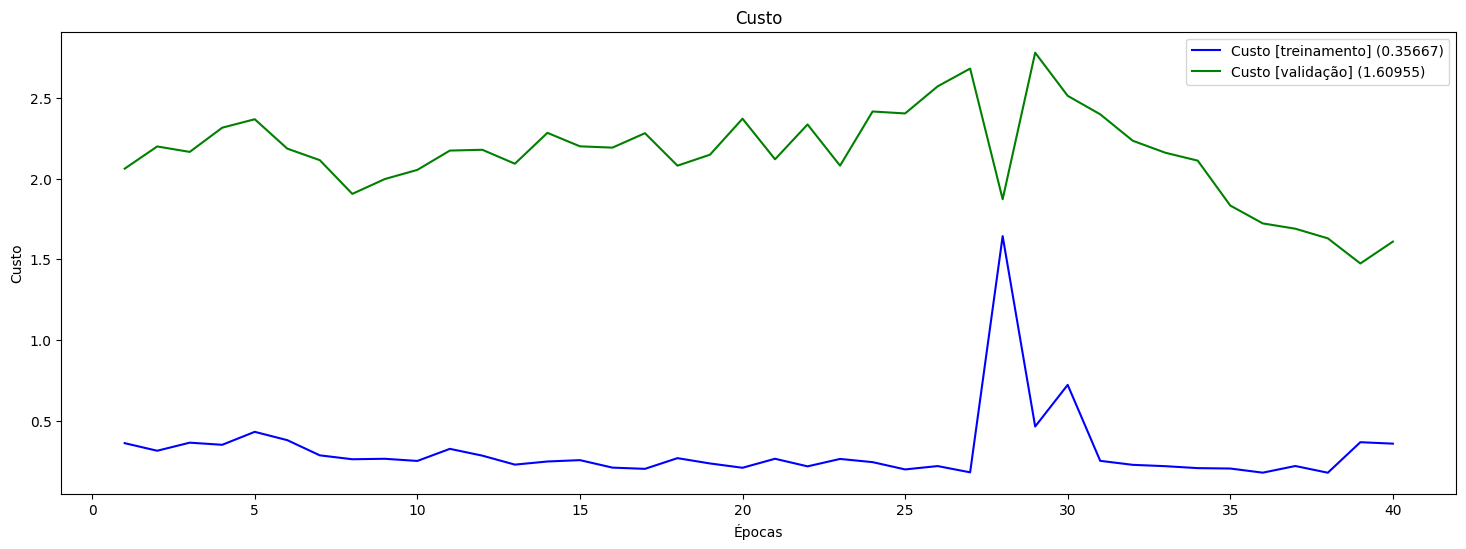

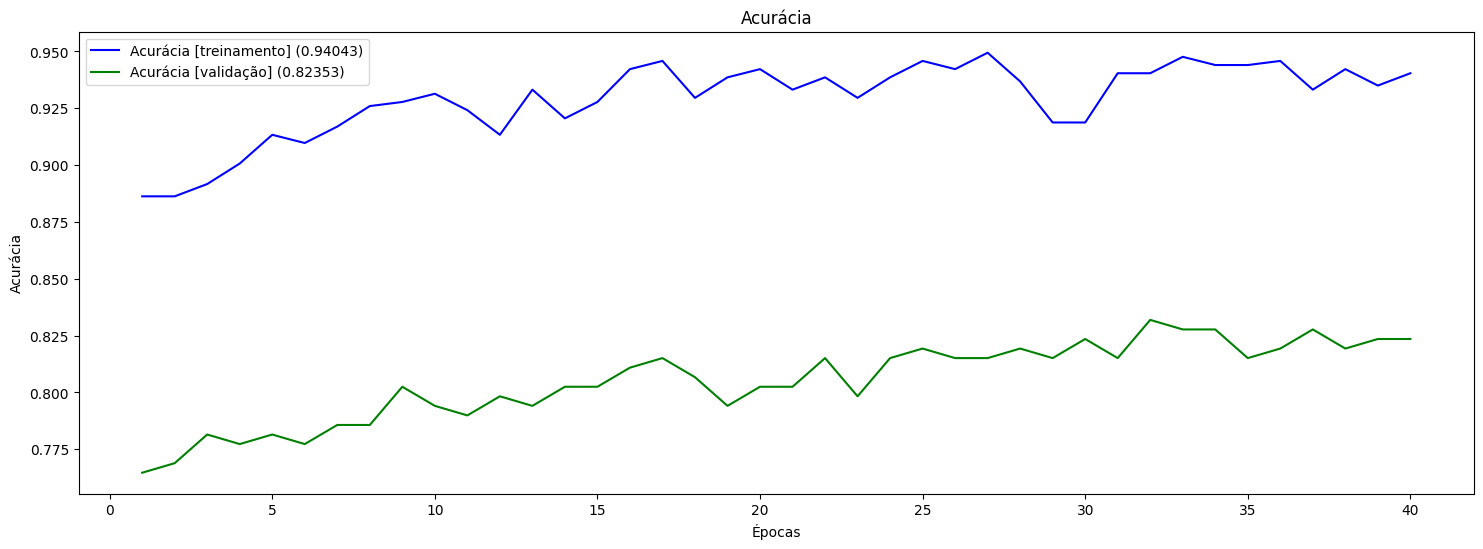

8/8 [==============================] - 0s 2ms/step - loss: 1.6096 - accuracy: 0.8235
Loss: 1.6095534563064575
Accuracy: 0.8235294222831726


In [32]:
history = model.fit(X_train, y_train, epochs=40, batch_size=8, validation_data=(X_test, y_test))
plot_history(history)
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

learning_rate=0.002: Esse parâmetro define a taxa de aprendizado do otimizador Adam. A taxa de aprendizado controla o tamanho do passo que o otimizador dá em direção ao mínimo global durante o treinamento da rede neural. Um valor de 0.002 significa que o otimizador ajustará os pesos da rede em incrementos ou decrementos proporcionais a esse valor.

regularizers.L1L2(l1=0.001, l2=0.001): Essa linha de código adiciona uma camada de regularização L1 e L2 às camadas densas do modelo. A regularização é usada para evitar o overfitting (sobreajuste) da rede neural, adicionando termos de penalização ao valor da função de perda. A regularização L1L2 combina a regularização L1 (Lasso) e L2 (Ridge), onde os valores de l1 e l2 definem a força da penalidade para os termos L1 e L2, respectivamente. Nesse caso, ambos os valores são definidos como 0.001.

epochs=50: Esse parâmetro determina o número de vezes que o conjunto de treinamento completo é percorrido durante o treinamento da rede neural. Cada passagem por todos os dados de treinamento é chamada de época. Um número maior de épocas permite que o modelo aprenda mais padrões nos dados, mas também pode levar ao overfitting se não for controlado adequadamente.

model.add(Dropout(0.01)): Essa linha de código adiciona uma camada de Dropout ao modelo. O Dropout é uma técnica de regularização comumente usada em redes neurais para reduzir o overfitting. Durante o treinamento, o Dropout desativa aleatoriamente uma fração dos neurônios da camada anterior, especificada pelo valor passado para ele (0.01 no seu caso, o que significa que 1% dos neurônios serão desativados). Isso ajuda a evitar que a rede se torne excessivamente dependente de neurônios específicos, forçando-a a aprender representações mais robustas.

Epoch 1/50
70/70 [==============================] - 1s 5ms/step - loss: 43.3418 - accuracy: 0.2274 - val_loss: 12.4108 - val_accuracy: 0.2689
Epoch 2/50
70/70 [==============================] - 0s 3ms/step - loss: 13.5504 - accuracy: 0.4079 - val_loss: 8.3170 - val_accuracy: 0.3908
Epoch 3/50
70/70 [==============================] - 0s 3ms/step - loss: 6.8149 - accuracy: 0.5072 - val_loss: 7.8992 - val_accuracy: 0.4790
Epoch 4/50
70/70 [==============================] - 0s 3ms/step - loss: 6.8476 - accuracy: 0.5361 - val_loss: 7.5154 - val_accuracy: 0.5210
Epoch 5/50
70/70 [==============================] - 0s 3ms/step - loss: 4.8555 - accuracy: 0.5812 - val_loss: 7.8429 - val_accuracy: 0.6008
Epoch 6/50
70/70 [==============================] - 0s 3ms/step - loss: 4.3437 - accuracy: 0.6480 - val_loss: 6.0495 - val_accuracy: 0.5924
Epoch 7/50
70/70 [==============================] - 0s 3ms/step - loss: 4.6200 - accuracy: 0.6877 - val_loss: 6.9874 - val_accuracy: 0.6555
Epoch 8/50
70/70 

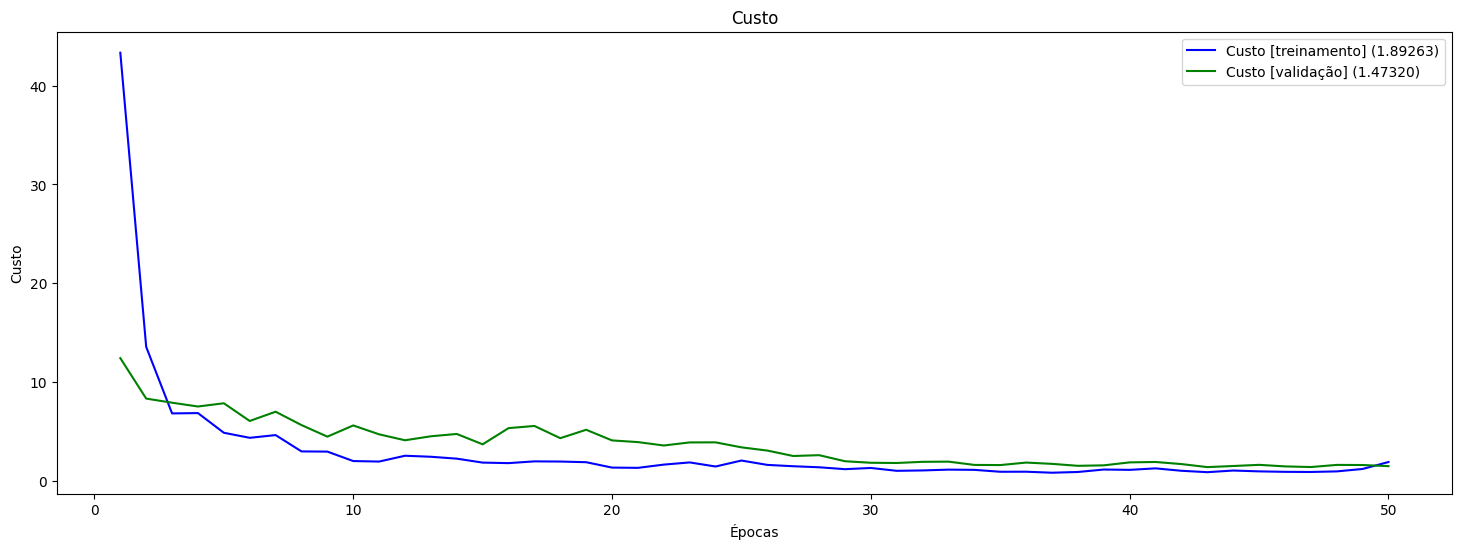

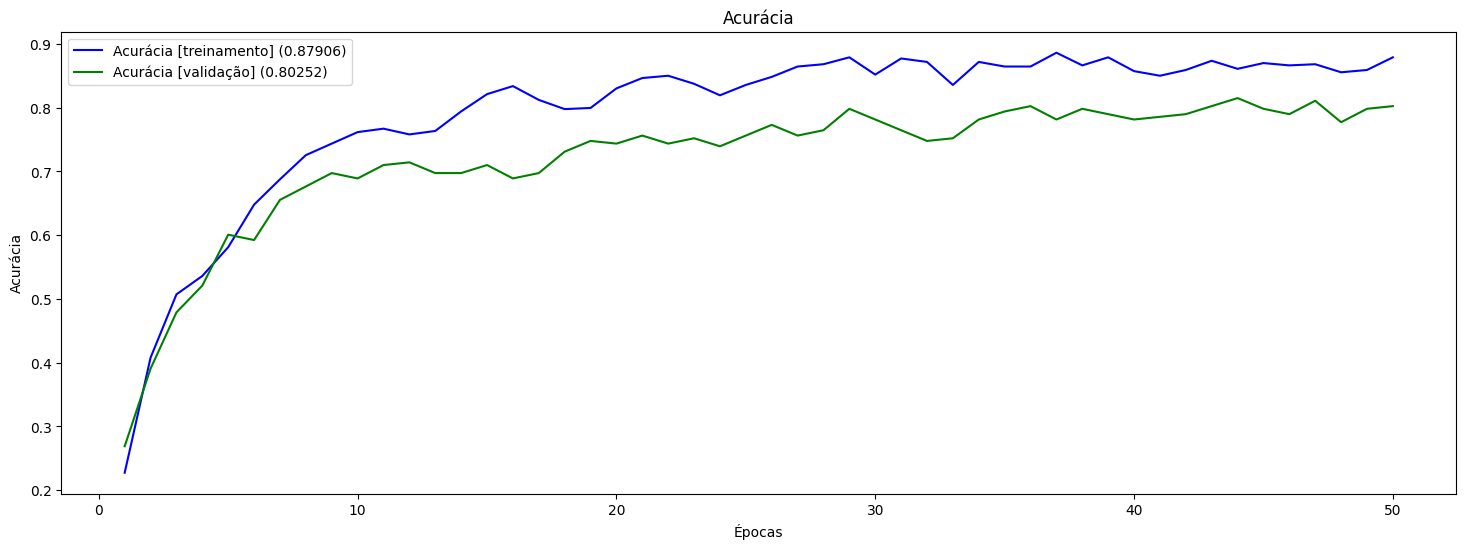

8/8 [==============================] - 0s 1ms/step - loss: 1.4732 - accuracy: 0.8025
Loss: 1.4731956720352173
Accuracy: 0.8025209903717041


In [106]:
from keras import regularizers
from keras import optimizers

opt = optimizers.Adam(learning_rate= 0.002)
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.001)))
model.add(Dropout(0.01))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.L1L2(l1=0.001, l2=0.001)))
model.add(Dropout(0.01))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))
plot_history(history)
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)